# Hedging Gold, US Treasuries and S&P 500 Project 
Author: Liu Xinran

Submission Date: 11/24/2023

In [1]:
#!pip install yfinance
#!pip install quantstats
#!pip install PyPortfolioOpt
#!pip install --upgrade openpyxl==3.0.10
#!pip install --upgrade seaborn

Task: 

Begin by defining economic regimes based on inflation or growth trends. Try to find the optimal hedge for the S&P 500 depending on which economic regime you are in. The hedges will be a mix of gold and US treasuries. You can include S&P 500, gold, and US treasuries in your portfolio. Try to optimize your portfolio across economic regimes.

Steps:
1. Data Preprocessing
2. Statistical Analysis
3. Portfolio Optmization with 4 methods (Train and Test)
4. Results comparison

Assumptions: 

1 unit will be allocated to gold, US trasuries and SP500. 

Metrics considered: 
1. Correlation between gold, US treasuries and SP500 close to -1
2. Total_Return maximize
3. Sharpe_Ratio	maximize
4. Max_Drawdown minimize

In [2]:
import numpy as np
from scipy.optimize import minimize
import quantstats as qs
import pandas as pd
import yfinance as yf
# Importing libraries for portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import cvxpy as cp
import warnings

warnings.filterwarnings("ignore")

c:\Users\irisx\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\irisx\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Data Preprocessing

In [3]:
# Replace 'path/to/Data_191023.xlsx' with the actual file path on your system
file_path = './Data_191023.xlsx'

import pandas as pd

# Read data from the 'Macro' sheet
data_sheet1 = pd.read_excel(file_path, sheet_name='Macro')

# Convert 'Date' column to datetime if needed
data_sheet1['Date'] = pd.to_datetime(data_sheet1['Date'])

# Set 'Date' column as the index
data_sheet1.set_index('Date', inplace=True)

# Create a date range to fill missing dates
full_date_range = pd.date_range(start=data_sheet1.index.min(), end=data_sheet1.index.max(), freq='D')

# Reindex the DataFrame with the full date range and fill missing values in 'GDP YOY' and 'CPI YOY' columns
data_sheet1 = data_sheet1.reindex(full_date_range)
data_sheet1['GDP YOY'] = data_sheet1['GDP YOY'].fillna(method='ffill')
data_sheet1['CPI YOY'] = data_sheet1['CPI YOY'].fillna(method='ffill')

# Reset the index to have 'Date' as a column again
data_sheet1.reset_index(inplace=True)
data_sheet1.rename(columns={'index': 'Date'}, inplace=True)
data_sheet2 = pd.read_excel(file_path, sheet_name='Prices').fillna(method='ffill')
data_sheet3 = pd.read_excel(file_path, sheet_name='Yield').fillna(method='ffill')

# Perform a right join on the 'Date' column
merged_data = pd.merge(data_sheet1, data_sheet2, on='Date', how='right')
final_merged_data = pd.merge(merged_data, data_sheet3, on='Date', how='left')

# Drop rows with NaN values resulting from the return calculation
df = final_merged_data
df = df.dropna()
df.reset_index(inplace=True,drop=True)

In [4]:
# get returns
df['Gold Returns'] = df['Gold'].pct_change()
df['UST Returns'] = df['US 10YR Bonds'].pct_change()
df['S&P 500 Returns'] = df['S&P 500'].pct_change()

# Drop rows with NaN values resulting from the return calculation
df = df.dropna()

# returns
sp500 = df.set_index('Date')['S&P 500 Returns']
gold = df.set_index('Date')['Gold Returns']
ust = df.set_index('Date')['UST Returns']

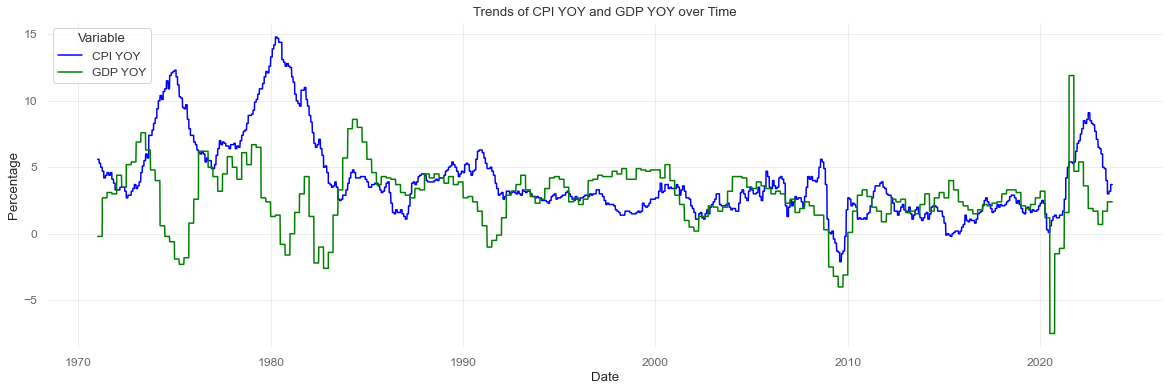

In [5]:
dates = df['Date'].values  

# Create a new DataFrame with 'Date', 'CPI YOY', and 'GDP YOY'
data = pd.DataFrame({'Date': dates, 'CPI YOY': df['CPI YOY'], 'GDP YOY': df['GDP YOY']})

plt.figure(figsize=(20, 6))
sns.lineplot(x='Date', y='value', hue='variable', data=pd.melt(data, ['Date']),
             palette={'CPI YOY': 'blue', 'GDP YOY': 'green'})
plt.title('Trends of CPI YOY and GDP YOY over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend(title='Variable')
plt.grid(True)
plt.show()

### Define thresholds for economic regimes

In [6]:
inflation_threshold = 3.0
deflation_threshold = 0.0
growth_threshold = 2.0

'''
Inflationary Regime: High CPI YOY and moderate/high GDP YOY.
Deflationary Regime: Low/negative GDP YOY and low CPI YOY.
Growth Regime: Moderate/high GDP YOY and moderate CPI YOY.
Recessionary Regime: Low/negative GDP YOY and moderate/high CPI YOY.
Expansionary Stagnation Regime: High GDP YOY and low CPI YOY.
'''

# Categorize periods into economic regimes based on thresholds
def categorize_regime(row):
    if row['GDP YOY'] > growth_threshold and row['CPI YOY'] > inflation_threshold:
        return "Inflationary"
    elif row['GDP YOY'] < deflation_threshold and row['CPI YOY'] < inflation_threshold:
        return "Deflationary"
    elif row['GDP YOY'] < growth_threshold and row['CPI YOY'] > inflation_threshold:
        return "Recessionary"
    elif row['GDP YOY'] > growth_threshold and row['CPI YOY'] < inflation_threshold:
        return "Expansionary Stagnation"
    else:
        return "Growth"


# Apply the categorization function to create a new column 'Economic Regime'
df['Regime'] = df.apply(categorize_regime, axis=1)
print('total:',df['Regime'].value_counts())

# save a copy
df_total = df
df

# Splitting the data into train and test sets based on date
train_size = 0.7
test_size = 0.3

train_data, test_data = train_test_split(df, test_size=test_size, shuffle=True,random_state=0)

# Separate DataFrames for training and testing
df_train = train_data.copy()
df_test = test_data.copy()
df_train.reset_index(inplace=True,drop=True)
df_test.reset_index(inplace=True,drop=True)
print('\ntrain set:',df_train['Regime'].value_counts())
print('\ntest set:',df_test['Regime'].value_counts())


total: Regime
Inflationary               4750
Expansionary Stagnation    4170
Recessionary               2172
Growth                     1927
Deflationary                479
Name: count, dtype: int64

train set: Regime
Inflationary               3329
Expansionary Stagnation    2878
Recessionary               1537
Growth                     1347
Deflationary                357
Name: count, dtype: int64

test set: Regime
Inflationary               1421
Expansionary Stagnation    1292
Recessionary                635
Growth                      580
Deflationary                122
Name: count, dtype: int64


## Statistical Analysis
some general analysis to get to know the relationhips and trends between the data.

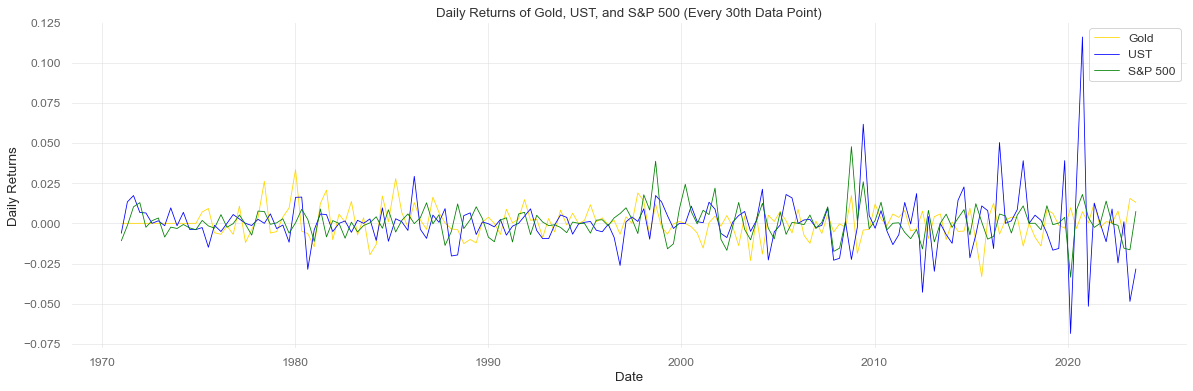

In [9]:
plt.figure(figsize=(20, 6))

# Plotting every 50th data point with a thinner line
plt.plot(gold.index[::80], gold.iloc[::80], label='Gold', color='gold', linewidth=0.8)
plt.plot(ust.index[::80], ust.iloc[::80], label='UST', color='blue', linewidth=0.8)
plt.plot(sp500.index[::80], sp500.iloc[::80], label='S&P 500', color='green', linewidth=0.8)

plt.title('Daily Returns of Gold, UST, and S&P 500 (Every 30th Data Point)')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid(True)
plt.show()


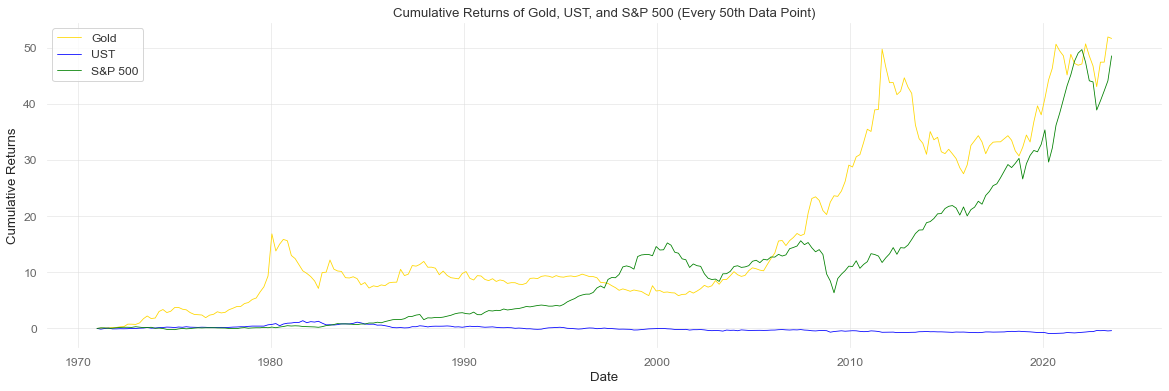

In [10]:
# Calculate cumulative returns
cumulative_gold = (1 + gold).cumprod() - 1
cumulative_ust = (1 + ust).cumprod() - 1
cumulative_sp500 = (1 + sp500).cumprod() - 1

plt.figure(figsize=(20, 6))

# Plotting cumulative returns for every 50th data point with thinner lines
plt.plot(cumulative_gold.index[::50], cumulative_gold.iloc[::50], label='Gold', color='gold', linewidth=0.8)
plt.plot(cumulative_ust.index[::50], cumulative_ust.iloc[::50], label='UST', color='blue', linewidth=0.8)
plt.plot(cumulative_sp500.index[::50], cumulative_sp500.iloc[::50], label='S&P 500', color='green', linewidth=0.8)

plt.title('Cumulative Returns of Gold, UST, and S&P 500 (Every 50th Data Point)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


Mean Returns in Different Regimes:
                         Gold Returns  UST Returns  S&P 500 Returns
Regime                                                             
Deflationary                 0.000471     0.003903         0.001037
Expansionary Stagnation      0.000219    -0.000017         0.000516
Growth                       0.000442     0.000007         0.000422
Inflationary                 0.000643     0.000120         0.000097
Recessionary                -0.000054    -0.000241         0.000327

Volatility (Standard Deviation) in Different Regimes:
                         Gold Returns  UST Returns  S&P 500 Returns
Regime                                                             
Deflationary                 0.011746     0.033166         0.014201
Expansionary Stagnation      0.009034     0.021623         0.009922
Growth                       0.009641     0.020646         0.010746
Inflationary                 0.012683     0.011251         0.009752
Recessionary              

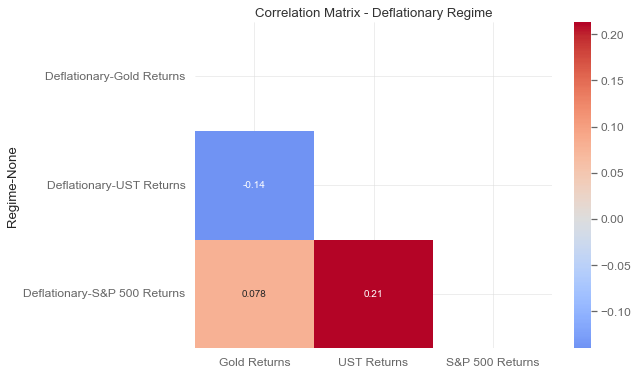

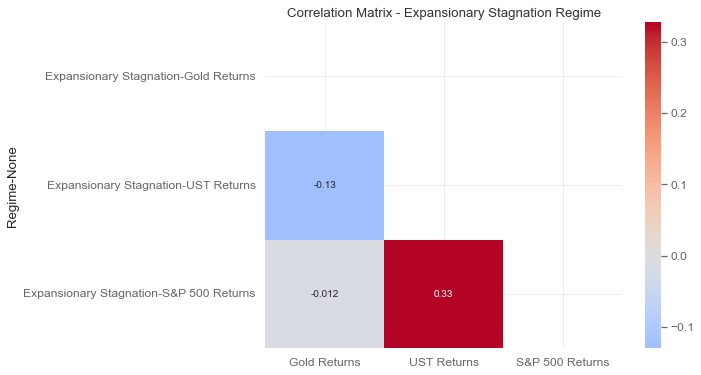

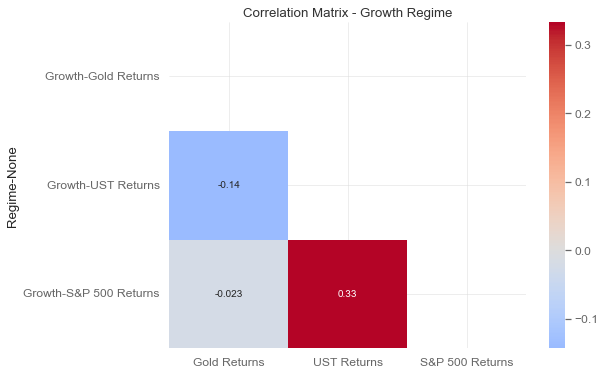

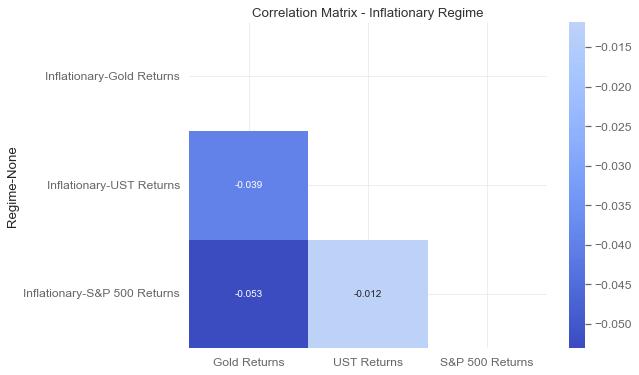

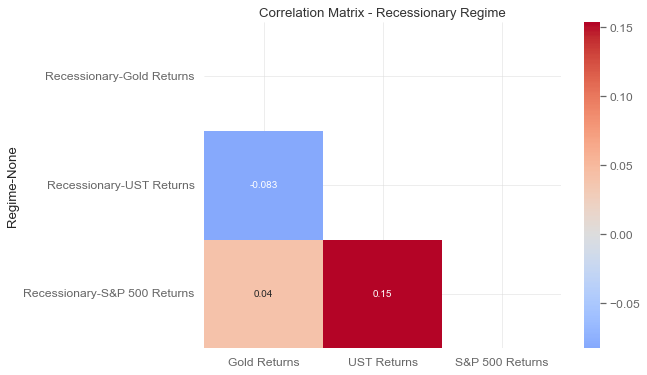

In [11]:
import pandas as pd

# Assuming you have a DataFrame 'data' with columns: Date, GDP YOY, CPI YOY, Gold Prices, US ustsuries, S&P 500, Regime

# Grouping the data by 'Regime'
grouped_data = df.groupby('Regime')

# Calculate mean returns for each asset in different regimes
mean_returns = grouped_data[['Gold Returns', 'UST Returns', 'S&P 500 Returns']].mean()

# Calculate volatility (standard deviation) for each asset in different regimes
volatility = grouped_data[['Gold Returns', 'UST Returns', 'S&P 500 Returns']].std()

# Calculate correlations among assets in different regimes
correlations = grouped_data[['Gold Returns', 'UST Returns', 'S&P 500 Returns']].corr()

# Display the calculated statistics
print("Mean Returns in Different Regimes:")
print(mean_returns)

print("\nVolatility (Standard Deviation) in Different Regimes:")
print(volatility)

print("\nCorrelation Matrix in Different Regimes:")
print(correlations)

for regime, data in correlations.groupby(level=0):
    mask = np.zeros_like(data, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, mask=mask, cmap='coolwarm', center=0)
    plt.title(f'Correlation Matrix - {regime} Regime')
    plt.show()

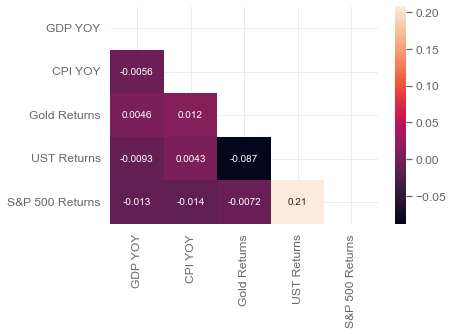

In [12]:
# Correlation Matrix for all
corr = df[['GDP YOY', 'CPI YOY', 'Gold Returns', 'UST Returns', 'S&P 500 Returns']].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask = mask)
plt.show()

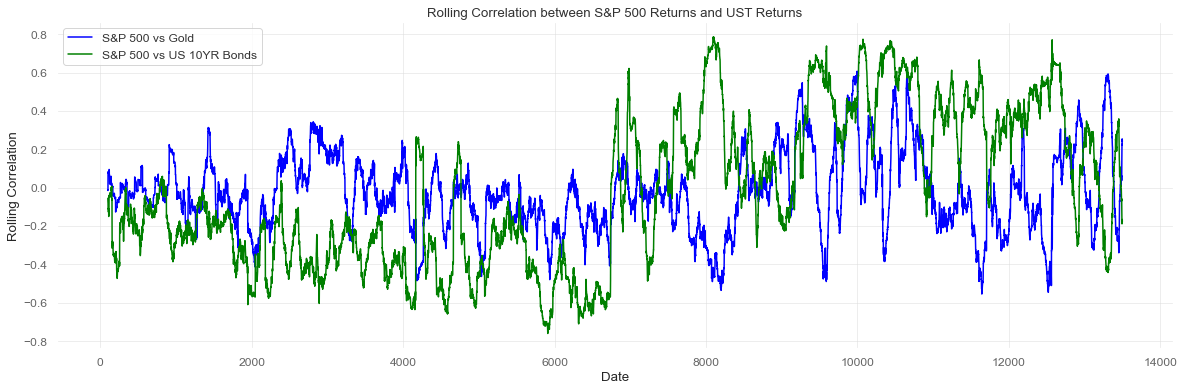

In [13]:
# Calculate the rolling correlation
rolling_window = 100  # Adjust the window size as needed
rolling_corr_gold = df['S&P 500 Returns'].rolling(window=rolling_window).corr(df['Gold Returns'])
rolling_corr_ust = df['S&P 500 Returns'].rolling(window=rolling_window).corr(df['UST Returns'])

# Plotting the rolling correlation
plt.figure(figsize=(20, 6))
plt.plot(rolling_corr_gold, label='S&P 500 vs Gold', color='blue')
plt.plot(rolling_corr_ust, label='S&P 500 vs US 10YR Bonds', color='green')

plt.title('Rolling Correlation between S&P 500 Returns and UST Returns')
plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Get unique regimes in the DataFrame
regimes = df['Regime'].unique()

# Iterate through each regime and calculate covariance matrix
for regime in regimes:
    regime_data = df[df['Regime'] == regime]
    gold_returns = regime_data['Gold Returns'].values
    ust_returns = regime_data['UST Returns'].values
    sp500_returns = regime_data['S&P 500 Returns'].values
    returns = np.column_stack([gold_returns, ust_returns, sp500_returns])

    # Calculate covariance matrix
    covariance_matrix = np.cov(returns, rowvar=False)
    
    # Create a DataFrame for covariance matrix with row and column names
    col_names = ['Gold', 'UST', 'S&P 500']
    cov_df = pd.DataFrame(covariance_matrix, columns=col_names, index=col_names)
    
    # Print regime and the corresponding covariance matrix
    print(f"Regime: {regime}")
    print("Covariance Matrix:")
    print(cov_df)
    print("\n")


Regime: Recessionary
Covariance Matrix:
             Gold       UST   S&P 500
Gold     0.000334 -0.000025  0.000010
UST     -0.000025  0.000266  0.000034
S&P 500  0.000010  0.000034  0.000183


Regime: Inflationary
Covariance Matrix:
             Gold       UST   S&P 500
Gold     0.000161 -0.000006 -0.000007
UST     -0.000006  0.000127 -0.000001
S&P 500 -0.000007 -0.000001  0.000095


Regime: Expansionary Stagnation
Covariance Matrix:
             Gold       UST   S&P 500
Gold     0.000082 -0.000025 -0.000001
UST     -0.000025  0.000468  0.000070
S&P 500 -0.000001  0.000070  0.000098


Regime: Growth
Covariance Matrix:
             Gold       UST   S&P 500
Gold     0.000093 -0.000028 -0.000002
UST     -0.000028  0.000426  0.000074
S&P 500 -0.000002  0.000074  0.000115


Regime: Deflationary
Covariance Matrix:
             Gold       UST   S&P 500
Gold     0.000138 -0.000054  0.000013
UST     -0.000054  0.001100  0.000100
S&P 500  0.000013  0.000100  0.000202




## Beta and Alpha

In [15]:
# Calculate beta for Gold
cov_gold_market = np.cov(gold, sp500)[0, 1]
var_market = np.var(sp500)
beta_gold = cov_gold_market / var_market

# Calculate beta for US Treasuries
cov_ust_market = np.cov(ust, sp500)[0, 1]
beta_ust = cov_ust_market / var_market

print("Beta for Gold:", beta_gold)
print("Beta for US Treasuries:", beta_ust)

Beta for Gold: -0.008302975528890982
Beta for US Treasuries: 0.34982189644689543


In [16]:
sp500_no_index = df['S&P 500 Returns'].reset_index(drop = True)
gold_no_index = df['Gold Returns'].reset_index(drop = True)
ust_no_index = df['UST Returns'].reset_index(drop = True)

# Fitting linear relation among Apple's returns and Benchmark
X = sp500_no_index.values.reshape(-1,1)
y = gold_no_index.values.reshape(-1,1)

linreg = LinearRegression().fit(X, y)

beta = linreg.coef_[0]
alpha = linreg.intercept_
print('\n')
print('gold beta: ', beta.round(3))
print('\ngold alpha: ', alpha.round(3))

# Fitting linear relation among Tesla's returns and Benchmark
X = sp500_no_index.values.reshape(-1,1)
y = ust_no_index.values.reshape(-1,1)

linreg = LinearRegression().fit(X, y)

beta = linreg.coef_[0]
alpha = linreg.intercept_
print('\n')
print('US 10YR Bonds beta: ', beta.round(3))
print('\nUS 10YR Bonds alpha: ', alpha.round(3))



gold beta:  [-0.008]

gold alpha:  [0.]


US 10YR Bonds beta:  [0.35]

US 10YR Bonds alpha:  [0.]


## Optimize Portfolio

### Define metrics

In [17]:
# Function to compute maximum drawdown
def max_drawdown(weights, returns):
    cumulative_returns = np.cumprod(1 + returns @ weights)
    peaks = np.maximum.accumulate(cumulative_returns)
    troughs = np.minimum.accumulate(cumulative_returns)
    drawdowns = (peaks - troughs) / peaks
    max_drawdown = np.max(drawdowns)
    return max_drawdown

def calculate_metrics(optimal_weights,gold_returns,ust_returns,sp500_returns):
    optimal_correlation = np.corrcoef(optimal_weights[0] * gold_returns + optimal_weights[1] * ust_returns, sp500_returns)[0, 1]
    total_portfolio_return = np.sum(optimal_weights[0] * gold_returns + optimal_weights[1] * ust_returns)
    mean_portfolio_return = np.mean(optimal_weights[0] * gold_returns + optimal_weights[1] * ust_returns)
    total_portfolio_std = np.std(optimal_weights[0] * gold_returns + optimal_weights[1] * ust_returns)
    sharpe_ratio = (mean_portfolio_return - 0.0) / total_portfolio_std  # Risk-free rate assumed as zero
    returns_3 = np.column_stack((gold_returns, ust_returns))
    optimal_drawdown = max_drawdown(optimal_weights, returns_3)
    
    return optimal_weights, optimal_correlation, total_portfolio_return, sharpe_ratio, optimal_drawdown

def calculate_metrics_new(optimal_weights,gold_returns,ust_returns,sp500_returns):
    correlation_sp500 = np.corrcoef(optimal_weights[0] * gold_returns + optimal_weights[1] * ust_returns, optimal_weights[2] * sp500_returns)[0, 1]
    total_portfolio_return = np.sum(optimal_weights[0] * gold_returns + optimal_weights[1] * ust_returns + optimal_weights[2] * sp500_returns)
    mean_portfolio_return = np.mean(optimal_weights[0] * gold_returns + optimal_weights[1] * ust_returns + optimal_weights[2] * sp500_returns)
    total_portfolio_std = np.std(optimal_weights[0] * gold_returns + optimal_weights[1] * ust_returns + optimal_weights[2] * sp500_returns)
    sharpe_ratio = (mean_portfolio_return - 0.0) / total_portfolio_std  # Risk-free rate assumed as zero
    returns_3 = np.column_stack((gold_returns, ust_returns, sp500_returns))
    optimal_drawdown = max_drawdown(optimal_weights, returns_3)
    
    return optimal_weights, correlation_sp500, total_portfolio_return, sharpe_ratio, optimal_drawdown

def print_metrics(optimal_weights, optimal_correlation, total_return, sharpe_ratio, optimal_drawdown):    
    print("Optimal Weights:", optimal_weights)
    print("Correlation:", optimal_correlation)
    print("Total Return:", total_return)
    print("Sharpe Ratio:", sharpe_ratio)
    print("Max Drawdown:", optimal_drawdown)
    print("-----------------------")

### Start with a portfolio of random combination of gold and ust

In [18]:
# initial random weights
# BEFORE optimization
weights = [0.5, 0.5] # Defining weights for gold and US Treasuries

def before_optimization(regime_data):
    
    # Simulated historical returns for the three assets
    gold_returns = regime_data['Gold Returns'].values
    ust_returns = regime_data['UST Returns'].values
    sp500_returns = regime_data['S&P 500 Returns'].values
    return calculate_metrics(weights,gold_returns,ust_returns,sp500_returns)

# Get unique regimes in the DataFrame
regimes = df['Regime'].unique()
# Iterate through each regime and optimize portfolio
for regime in regimes:
    regime_data = df[df['Regime'] == regime]
    optimal_weights, optimal_correlation, total_return, sharpe_ratio, optimal_drawdown = before_optimization(regime_data)
    
    print(f"Regime: {regime}")
    #print_metrics(optimal_weights, optimal_correlation, total_return, sharpe_ratio, optimal_drawdown)
    
portfolio = gold*weights[0] + ust*weights[1] 
# if you wnat to see the reports for the portfolio you can use the following codes
#qs.reports.basic(portfolio, benchmark = sp500)
#qs.reports.full(portfolio, benchmark = sp500)

Regime: Recessionary
Regime: Inflationary
Regime: Expansionary Stagnation
Regime: Growth
Regime: Deflationary


## Train Step

### Method 1. random iterations to maximize sharpe and minimize max drawdown and correlation close to -1

In [19]:
# Function to optimize portfolio for each regime
def optimize_function_1(regime_data):
    
    # Simulated historical returns for the three assets
    gold_returns = regime_data['Gold Returns'].values
    ust_returns = regime_data['UST Returns'].values
    sp500_returns = regime_data['S&P 500 Returns'].values
    returns = np.column_stack([gold_returns, ust_returns, sp500_returns])
    best_weights = None
    best_sharpe = float('-inf')
    best_drawdown = float('inf')

    # Perform optimization iterations
    iterations = 10000  # Number of iterations
    for _ in range(iterations):
        # Generate random weights
        weights = np.random.random(3)
        weights /= np.sum(weights)  # Ensure weights sum up to 1

        # Calculate metrics
        weights, current_correlation, current_portfolio_return, current_sharpe, current_drawdown = calculate_metrics_new(weights,gold_returns,ust_returns,sp500_returns)
        current_corr_constraint = abs(current_correlation+1)

        # Update best weights if new solution is better
        if current_sharpe > best_sharpe and current_drawdown < best_drawdown and current_corr_constraint < 1.1:  # Adjust the threshold
            best_weights = weights
            best_sharpe = current_sharpe
            best_drawdown = current_drawdown

    return calculate_metrics_new(best_weights,gold_returns,ust_returns,sp500_returns)


### Method 2. Using CVXPY with beta constraints and minimize variance 

In [20]:
def optimize_function_2(regime_data):
    gold_returns = regime_data['Gold Returns'].values
    ust_returns = regime_data['UST Returns'].values
    sp500_returns = regime_data['S&P 500 Returns'].values

    # Define the target portfolio beta and risk-free rate
    target_portfolio_beta = 0  # Set your desired portfolio beta here
    risk_free_rate = 0  # Set your risk-free rate here

    # Calculate betas of Gold and US Treasuries relative to S&P 500
    beta_gold_sp500 = np.cov(gold_returns, sp500_returns)[0, 1] / np.var(sp500_returns)
    beta_ust_sp500 = np.cov(ust_returns, sp500_returns)[0, 1] / np.var(sp500_returns)

    # Portfolio Optimization using CVXPY
    weights = cp.Variable(3)  # Three assets: Gold, UST, S&P 500

    # Objective function - minimize portfolio risk
    cov_matrix = np.cov(np.column_stack([gold_returns, ust_returns, sp500_returns]), rowvar=False)
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)

    # Constraints: mean return, beta constraint, fully invested
    constraints = [
        cp.sum(weights) == 1,  # Fully invested
        weights.T @ np.array([1, 1, 1]) == 1,  # Weights sum to 1
        weights.T @ np.array([beta_gold_sp500, beta_ust_sp500, 1]) == target_portfolio_beta,  # Portfolio beta constraint
        # Add additional constraints if needed
    ]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    optimal_weights = weights.value

    return calculate_metrics_new(optimal_weights, gold_returns, ust_returns, sp500_returns)

### Method 3.  Maximize total return and sharpe ratio, correlation close to -1, using scipy minimize function and self-defined weights.

In [21]:
# Function to optimize portfolio for each regime
def optimize_function_3(regime_data):
    gold_returns = regime_data['Gold Returns'].values
    ust_returns = regime_data['UST Returns'].values
    sp500_returns = regime_data['S&P 500 Returns'].values

    def combined_objective(weights):
        weighted_gold_ust_returns = weights[0] * gold_returns + weights[1] * ust_returns
        portfolio_return = weights[0] * gold_returns + weights[1] * ust_returns + weights[2] * sp500_returns
        
        # Absolute value to minimize correlation, make the correaltion as close to -1 as possible.
        correlation = np.corrcoef(weighted_gold_ust_returns, weights[2] * sp500_returns)[0, 1]
        objective1 = abs(correlation + 1)

        total_portfolio_return = np.sum(portfolio_return)
        objective2 = -total_portfolio_return # Negative because we want to maximize total_portfolio_return

        total_portfolio_std = np.std(portfolio_return)
        risk_free_rate = 0.0  # Assuming risk-free rate is zero
        sharpe_ratio = (total_portfolio_return - risk_free_rate) / total_portfolio_std
        objective3 = -sharpe_ratio  # Negative because we want to maximize Sharpe ratio
        
        # Assign weights to the objectives (adjust these weights based on priority)
        w1 = 1  # Weight for minimizing correlation
        w2 = 0.3  # Weight for maximizing total return
        w3 = 0.3  # Weight for maximizing Sharpe ratio  

        combined_objective_value = w1 * objective1 + w2 * objective2 + w3 * objective3
        return combined_objective_value

    initial_guess = [0.33,0.33,0.34]
    constraints = ({'type': 'eq', 'fun': lambda w: 1 - np.sum(w)})
    bounds = ((-2, 2), (-2, 2),(-2, 2))

    result = minimize(combined_objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return calculate_metrics_new(optimal_weights,gold_returns,ust_returns,sp500_returns)
   

### Method 4. Markowitz Mean-Variance Optimization Model with Efficient Frontier

The Markowitz Mean-Variance Optimization Model is a widely-used framework for constructing portfolios with the best risk-return relationship. It is based on the idea that investors should maximize the expected return of a portfolio while minimizing its risk.

Modern portfolio theory (MPT), uses diversification to create groups of assets that reduce volatility. MPT uses statistical measures to determine an efficient frontier for an expected amount of return for a defined amount of risk. The theory examines the correlation between different assets, as well as the volatility of assets, to create an optimal portfolio.

In [22]:
def optimize_function_4(regime_data):
    gold_returns = regime_data['Gold Returns'].values
    ust_returns = regime_data['UST Returns'].values
    sp500_returns = regime_data['S&P 500 Returns'].values

    var_df_regime = regime_data[['Gold Returns', 'UST Returns', 'S&P 500 Returns']].copy()
    var_df_regime.set_index(regime_data['Date'], inplace=True)  # Assuming 'Date' column is present

    # Calculate expected returns and covariance matrix
    mu = expected_returns.mean_historical_return(var_df_regime,returns_data=True)
    S = risk_models.semicovariance(var_df_regime, returns_data=True,benchmark=0)  # Use semicovariance directly

    # Define the Efficient Frontier object
    ef = EfficientFrontier(mu, S, weight_bounds=(-1,1))

    # Optimize for maximum Sharpe ratio
    weights = ef.max_sharpe()

    # Get clean weights (removes any weights below a certain threshold)
    clean_weights_regime = ef.clean_weights()

    new_weights_regime = [clean_weights_regime['Gold Returns'], clean_weights_regime['UST Returns'], clean_weights_regime['S&P 500 Returns']]
    optimal_weights = new_weights_regime
    #ef.portfolio_performance(verbose=False, risk_free_rate=0)

    return calculate_metrics_new(optimal_weights, gold_returns, ust_returns, sp500_returns)

In [23]:
# Initialize an empty list to store results
results_list = []

# Get unique regimes in the DataFrame
regimes = df['Regime'].unique()
methods = [before_optimization,optimize_function_1, optimize_function_2, optimize_function_3, optimize_function_4]

# Iterate through each regime and optimize portfolio
for regime in regimes:
    for method in methods:
        regime_data = df_train[df_train['Regime'] == regime]
        optimal_weights, optimal_correlation, total_return, sharpe_ratio, optimal_drawdown = method(regime_data)
        
        # Store results in a dictionary
        result_dict = {
            'Method': method.__name__,
            'Regime': regime,
            'Optimal_Weights': optimal_weights,
            'Correlation': optimal_correlation,
            'Total_Return': total_return,
            'Sharpe_Ratio': sharpe_ratio,
            'Max_Drawdown': optimal_drawdown
        }
        results_list.append(result_dict)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)

In [24]:
# Function to format the weights array
def format_weights(weights):
    return [f'{w:.5f}' for w in weights[:5]]  # Show only the first 5 digits

def produce_ranked_df(results_df,regimes,columns_to_rank_asc,columns_to_rank_des):
    # Initialize a new DataFrame to store ranked values
    ranked_df = pd.DataFrame()

    # Iterate through each regime
    for regime in regimes:
        regime_data = results_df[results_df['Regime'] == regime]
        
        # Rank columns within each regime
        ranked_regime = regime_data.copy()
        for column in columns_to_rank_asc:
            ranked_regime[f'{column}_Rank'] = regime_data[column].rank(ascending=True)
        for column in columns_to_rank_des:
            ranked_regime[f'{column}_Rank'] = regime_data[column].rank(ascending=False)
        
        # Append ranked regime data to the final DataFrame
        # Summing up the ranks for each row
        ranked_regime['final_score'] = ranked_regime[[f'{col}_Rank' for col in columns_to_rank_asc + columns_to_rank_des]].sum(axis=1)
        
        # Append ranked regime data to the final DataFrame
        ranked_df = pd.concat([ranked_df, ranked_regime], ignore_index=True)
    # Apply formatting to the 'Optimal_Weights' column
    ranked_df['Optimal_Weights'] = ranked_df['Optimal_Weights'].apply(format_weights)
    return ranked_df

# List of columns to rank within each regime
columns_to_rank_asc = [ 'Correlation', 'Max_Drawdown']
columns_to_rank_des = [ 'Total_Return', 'Sharpe_Ratio']
ranked_df = produce_ranked_df(results_df,regimes,columns_to_rank_asc,columns_to_rank_des)

In [25]:
# Group by 'Regime' and find rows with the smallest final_rank within each regime
min_rank_indices = ranked_df.groupby('Regime')['final_score'].idxmin()
min_rank_rows = ranked_df.loc[min_rank_indices]

# If there are ties within each group, choose the row with the highest Sharpe_Ratio rank
df_final = min_rank_rows.groupby('Regime').apply(lambda x: x.nlargest(1, 'Sharpe_Ratio_Rank'))

# Resetting the index of the resulting DataFrame
df_final.reset_index(drop=True, inplace=True)

# Now 'df_final' contains the rows with the smallest final_rank and, if necessary, the highest Sharpe_Ratio rank among them
df_final

,Method,Regime,Optimal_Weights,Correlation,Total_Return,Sharpe_Ratio,Max_Drawdown,Correlation_Rank,Max_Drawdown_Rank,Total_Return_Rank,Sharpe_Ratio_Rank,final_score
0,optimize_function_3,Deflationary,"[0.51984, 0.48016, -0.00000]",-0.203683,0.668388,0.113490,0.516433,1.0,3.0,3.0,1.0,8.0
1,optimize_function_3,Expansionary Stagnation,"[0.37738, -0.00826, 0.63087]",-0.023076,1.176024,0.056519,0.700046,3.0,4.0,2.0,1.0,10.0
2,optimize_function_1,Growth,"[0.73726, 0.08466, 0.17809]",0.054054,0.757675,0.077723,0.550677,3.0,1.0,3.0,2.0,9.0
3,optimize_function_1,Inflationary,"[0.27872, 0.34342, 0.37787]",-0.072437,1.158648,0.059459,0.719499,2.0,1.0,5.0,2.0,10.0
4,optimize_function_1,Recessionary,"[0.39816, 0.28494, 0.31690]",0.099784,0.351340,0.023672,0.443636,3.0,2.0,3.0,2.0,10.0


## Test Step

In [26]:
results_list_test=[]
for index, row in df_final.iterrows():
    regime = row['Regime']
    optimal_weights = row['Optimal_Weights']
    # Converting strings to floats
    optimal_weights = [float(weight) for weight in optimal_weights]
    # Get the corresponding data for the regime from df_test
    regime_data = df_test[df_test['Regime'] == regime]
    
    # Simulated historical returns for the three assets
    gold_returns = regime_data['Gold Returns'].values
    ust_returns = regime_data['UST Returns'].values
    sp500_returns = regime_data['S&P 500 Returns'].values

    # Call your existing function to calculate metrics
    optimal_weights, optimal_correlation, total_return, sharpe_ratio, optimal_drawdown = calculate_metrics_new(optimal_weights, gold_returns, ust_returns, sp500_returns)

    # Store results in a dictionary
    result_dict = {
        'Method': 'After optimization',
        'Regime': regime,
        'Optimal_Weights': optimal_weights,
        'Correlation': optimal_correlation,
        'Total_Return': total_return,
        'Sharpe_Ratio': sharpe_ratio,
        'Max_Drawdown': optimal_drawdown
    }
    results_list_test.append(result_dict)

# Convert results_list to a DataFrame
results_df_test = pd.DataFrame(results_list_test)
results_df_test

,Method,Regime,Optimal_Weights,Correlation,Total_Return,Sharpe_Ratio,Max_Drawdown
0,After optimization,Deflationary,"[0.51984, 0.48016, -0.0]",NaN,0.346401,0.184780,0.309382
1,After optimization,Expansionary Stagnation,"[0.37738, -0.00826, 0.63087]",-0.042977,0.527172,0.061417,0.442698
2,After optimization,Growth,"[0.73726, 0.08466, 0.17809]",0.068393,0.016050,0.003522,0.166586
3,After optimization,Inflationary,"[0.27872, 0.34342, 0.37787]",0.001688,0.062687,0.006411,0.282707
4,After optimization,Recessionary,"[0.39816, 0.28494, 0.3169]",0.171374,-0.322153,-0.050254,0.505308


In [27]:
results_list_test_before=[]
# Iterate through each regime and optimize portfolio
for regime in regimes:
    regime_data = df_test[df_test['Regime'] == regime]    # Simulated historical returns for the three assets
    gold_returns = regime_data['Gold Returns'].values
    ust_returns = regime_data['UST Returns'].values
    sp500_returns = regime_data['S&P 500 Returns'].values

    optimal_weights=[0.5,0.5]
    # Call your existing function to calculate metrics
    optimal_weights, optimal_correlation, total_return, sharpe_ratio, optimal_drawdown = calculate_metrics(optimal_weights, gold_returns, ust_returns, sp500_returns)
        
    # Store results in a dictionary
    result_dict = {
        'Method': 'Before optimization',
        'Regime': regime,
        'Optimal_Weights': optimal_weights,
        'Correlation': optimal_correlation,
        'Total_Return': total_return,
        'Sharpe_Ratio': sharpe_ratio,
        'Max_Drawdown': optimal_drawdown
    }
    results_list_test_before.append(result_dict)

# Convert results_list to a DataFrame
results_df_test_before = pd.DataFrame(results_list_test_before)
results_df_test_before

,Method,Regime,Optimal_Weights,Correlation,Total_Return,Sharpe_Ratio,Max_Drawdown
0,Before optimization,Recessionary,"[0.5, 0.5]",0.204434,-0.639116,-0.084603,0.629445
1,Before optimization,Inflationary,"[0.5, 0.5]",-0.007240,0.367114,0.028820,0.378682
2,Before optimization,Expansionary Stagnation,"[0.5, 0.5]",0.223379,-0.406727,-0.036451,0.483959
3,Before optimization,Growth,"[0.5, 0.5]",0.311653,-0.386599,-0.060721,0.435148
4,Before optimization,Deflationary,"[0.5, 0.5]",0.346065,0.355602,0.183716,0.316971


In [28]:
# Concatenate the two DataFrames
concatenated_df = pd.concat([results_df_test_before,results_df_test])

# Sort the concatenated DataFrame by the "Regime" column
sorted_concatenated_df = concatenated_df.sort_values(by='Regime')
sorted_concatenated_df.reset_index(inplace=True,drop=True)
sorted_concatenated_df
# compare before optimization where there are 0.5/0.5 gold/us treasuries and the optimized weights.

,Method,Regime,Optimal_Weights,Correlation,Total_Return,Sharpe_Ratio,Max_Drawdown
0,Before optimization,Deflationary,"[0.5, 0.5]",0.346065,0.355602,0.183716,0.316971
1,After optimization,Deflationary,"[0.51984, 0.48016, -0.0]",NaN,0.346401,0.184780,0.309382
2,Before optimization,Expansionary Stagnation,"[0.5, 0.5]",0.223379,-0.406727,-0.036451,0.483959
3,After optimization,Expansionary Stagnation,"[0.37738, -0.00826, 0.63087]",-0.042977,0.527172,0.061417,0.442698
4,Before optimization,Growth,"[0.5, 0.5]",0.311653,-0.386599,-0.060721,0.435148
5,After optimization,Growth,"[0.73726, 0.08466, 0.17809]",0.068393,0.016050,0.003522,0.166586
6,Before optimization,Inflationary,"[0.5, 0.5]",-0.007240,0.367114,0.028820,0.378682
7,After optimization,Inflationary,"[0.27872, 0.34342, 0.37787]",0.001688,0.062687,0.006411,0.282707
8,Before optimization,Recessionary,"[0.5, 0.5]",0.204434,-0.639116,-0.084603,0.629445
9,After optimization,Recessionary,"[0.39816, 0.28494, 0.3169]",0.171374,-0.322153,-0.050254,0.505308


Thank you for spending time to read this project. If there are any misconceptions, mistakes or room for improvements, do let me know :)